In [1]:
import cv2
import glob
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
import random
from scipy import ndimage
import skimage
from utils import pre_process

plt.style.use("fivethirtyeight")
%matplotlib inline

Using TensorFlow backend.


In [2]:
SIMULATOR_HOME = "/Users/ddigges/simulator/data/"
DRIVING_LOG_FILE = "driving_log.csv"
DRIVING_LOG_FILE_PATH = os.path.join(SIMULATOR_HOME, DRIVING_LOG_FILE)

IMAGE_PATH = os.path.join(SIMULATOR_HOME, "IMG")

steering_offset = 0.25

In [3]:
driving_log = pd.read_csv(DRIVING_LOG_FILE_PATH)
driving_log.columns = ["center", "left", "right", "steering", "throttle", "brake", "speed"]

In [4]:
def invert(df, drop_zeros=True):
    """
        1. Create a copy of the data frame
        2. Reverse each angle by multiplying by -1
        3. Append "INV" to image path
    """
    inv_df = df.copy()
    
    if(drop_zeros):
        inv_df = inv_df[inv_df.angle != 0]
    
    inv_df.angle *= -1
    inv_df.image += "INV"
    return inv_df

In [5]:
def get_copy(df, column, angle_offset=0):
    """
        Return a new data frame from the passed df
        where:
        1. column: is one of "left", "right", "center"
        
        The returned df will have column and the angle from the passed df
        
        If an angle offset is passed, it will be added to all rows in the angle column
    """
    res = df.copy()[[column, "steering"]]
    res.columns = ["image", "angle"]
    res.angle += angle_offset
    return res

In [6]:
# Construct augmented data set

# Center image, angle unchanged
center = get_copy(driving_log, "center")
center_zeros = center[center.angle == 0]
center = center[center.angle != 0]
center_zeros = center_zeros.sample(frac=0.5).reset_index(drop=True)
center = pd.concat([center, center_zeros])

# Center image, filter zero angles
# invert angle, flip image
center_inverted = invert(center)

# Gaussian blur
center_blur = get_copy(driving_log, "center")
center_blur = center_blur[center_blur.angle != 0]
center_blur.image += "BLUR"

# Gaussian Noise
center_noise = get_copy(driving_log, "center")
center_noise = center_noise[center_noise.angle != 0]
center_noise.image += "NOISE"

# Left image, Add steering offset
left = get_copy(driving_log, "left")
left.angle += steering_offset
left = left.sample(frac=0.2).reset_index(drop=True)

# Right image, subtract steering offset
right = get_copy(driving_log, "right")
right.angle -= steering_offset
right = right.sample(frac=0.2).reset_index(drop=True)

all_data = pd.concat([center, center_inverted, left, right, center_blur, center_noise])
                      #, center_inverted, left, right, center_blur, center_blur])


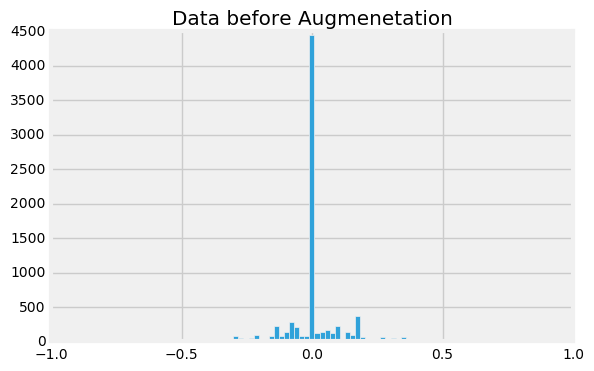

In [7]:
plt.hist(get_copy(driving_log, "center").angle, bins=100);
plt.title("Data before Augmenetation");

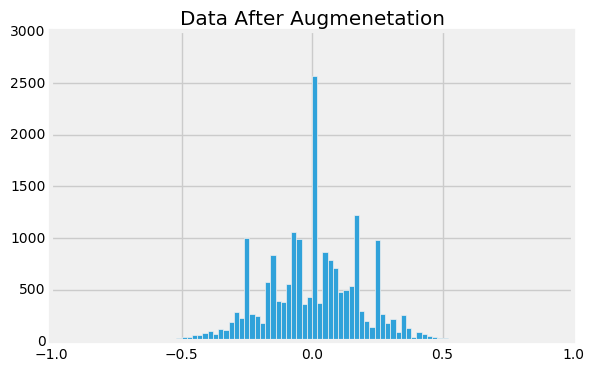

In [8]:
plt.hist(all_data.angle, bins=100);
plt.title("Data After Augmenetation");

In [9]:
n = all_data.shape[0]
batch_size = 64
samples_per_epoch = int(n/batch_size)

In [10]:
def get_flipped_image(image_name):
    """
        returns image which is flipped about the vertical axis
    """
    image = cv2.imread(os.path.join(SIMULATOR_HOME, image_name))
    image = cv2.flip(image, 1)
    return image

In [11]:
def get_blurred_image(image_name):
    """
        image_name: file path of the image 
        Performs a gaussian blur on the image and returns it
    """
    image = cv2.imread(os.path.join(SIMULATOR_HOME, image_name))
    return ndimage.gaussian_filter(image, sigma=1)

In [12]:
def get_speckled_image(image_name):
    image = cv2.imread(os.path.join(SIMULATOR_HOME, image_name))
    return skimage.img_as_ubyte(skimage.util.random_noise(image.astype(np.uint8), mode='gaussian'))

In [13]:
def get_image(row):
    image_name = row["image"].strip()
    
    if image_name.endswith("INV"):
        image = get_flipped_image(image_name.replace("INV", ""))

    elif image_name.endswith("BLUR"):
        image = get_blurred_image(image_name.replace("BLUR", ""))
    
    elif image_name.endswith("NOISE"):
        image = get_speckled_image(image_name.replace("NOISE", ""))
    
    else:
        image = cv2.imread(os.path.join(SIMULATOR_HOME, image_name))

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [14]:
def data_generator(df, batch_size=128):
    """
        yields a pair (X, Y) where X and Y are both numpy arrays of length `batch_size`
    """
    n_rows = df.shape[0]
    while True:
        # Shuffle the data frame rows after every complete cycle through the data
        df = df.sample(frac=1).reset_index(drop=True)
        
        for index in range(0, n_rows, batch_size):
            df_batch = df[index: index + batch_size]

            # Ignoring the last batch which is smaller than the requested batch size
            if(df_batch.shape[0] == batch_size):
                X_batch = np.array([pre_process(get_image(row)) for i, row in df_batch.iterrows()])
                y_batch = np.array([row['angle'] for i, row in df_batch.iterrows()])
                yield X_batch, y_batch

In [15]:
gen = data_generator(all_data, batch_size=batch_size)
X_batch, y_batch = next(gen)

/Users/ddigges/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [16]:
def plot_batch(X, y, batch_size):
    num_cols = 8
    num_rows = math.ceil(batch_size/num_cols)
    
    fig = plt.figure(1)

    gs = gridspec.GridSpec(num_rows, num_cols)

    ax = [plt.subplot(gs[i]) for i in range(num_rows * num_cols)]

    gs.update(hspace=0)

    for i in range(len(X)):
        axes = ax[i]
        axes.imshow(X[i], aspect='auto')
        #axes.set_title("Angle" + str(y[i]))
        axes.axis('off')
    plt.show()

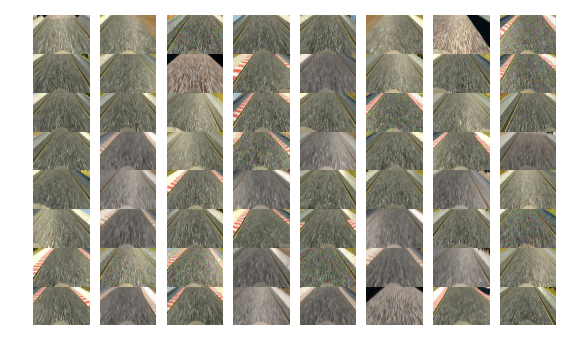

In [17]:
plot_batch(X_batch, y_batch, batch_size)

In [18]:
input_shape = (X_batch.shape[1], X_batch.shape[2], X_batch.shape[3])
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=input_shape,
            output_shape=input_shape))

model.add(Convolution2D(16, 5, 5, subsample=(4, 4), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(32, 3, 3, subsample=(2, 2), border_mode="same"))
model.add(ELU())
model.add(Convolution2D(64, 3, 3, subsample=(2, 2), border_mode="same"))
model.add(Flatten())
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(ELU())
model.add(Dense(1))

In [19]:
adam = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss="mse")

In [20]:
model.fit_generator(gen, samples_per_epoch=samples_per_epoch*batch_size, nb_epoch=1)

Epoch 1/1


/Users/ddigges/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


20032/20032 [==============================] - 92s - loss: 0.0354    


In [21]:
model.save_weights("model.h5")
file = open("model.json", "w")
file.write(model.to_json())
file.close()

/Users/ddigges/anaconda/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))
